In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re 
import nltk 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OrdinalEncoder
from textblob import TextBlob
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

from scipy.sparse import hstack


#nltk.download('s')

In [227]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [229]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lena\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [350]:
class FakeNewsPipeline:
    
    def __init__(self, train_file, test_file, valid_file, columns):       
        
        self.train_df = pd.read_csv(train_file, sep=',', names = columns)
        self.test_df = pd.read_csv(test_file, sep=',', names = columns)
        self.valid_df = pd.read_csv(valid_file, sep=',', names = columns)
        self.columns = columns

    # Data sets overviews 
    def dataset_overview(self):
        
        for df, name in zip([self.train_df, self.test_df, self.valid_df], ['Train', 'Test', 'Validation']):
            
            df = df[df['Label'] != 'Label']
            print(f"{name} DataFrame Overview:")
            print(df.head(10))
            print(df.tail(10))
            print(df.info())
            print(df.describe(include='all'))
            print("\n")
        
        print("Datasets overview printed!")
    
    def handle_missing_values(self):
        
        # Dropping ID column
        self.train_df.drop(['ID'], axis=1, inplace=True)
        self.test_df.drop(['ID'], axis=1, inplace=True)
        self.valid_df.drop(['ID'], axis=1, inplace=True)
        
        # Removing rows with values missing from max. columns
        rows_to_drop = [1280, 2154, 6132, 6193, 7571, 9404]
        self.train_df.drop(index=rows_to_drop, inplace=True)

        # Visualize missing values in train set 
        sns.heatmap(self.train_df.isnull(), cbar=False, yticklabels = False, cmap="cividis")
        plt.title("Missing Values in the Train Dataset")
        plt.show()
        
        # Substitute NaNs in categorical columns with Unknown 
        categorical_columns = ['Job Title', 'State', 'Context', 'Party', 'Speaker','Subject']
        for df in [self.train_df, self.test_df, self.valid_df]:
            df[categorical_columns] = df[categorical_columns].fillna('Unknown')
        
        # List of credibility history count columns
        credibility_columns = [
        "Barely True Count", 
        "False Count", 
        "Half True Count", 
        "Mostly True Count", 
        "Pants on Fire Count"
        ]

        # Remove rows with NaN in any of the credibility history columns
        train_df_cleaned = self.train_df.dropna(subset=credibility_columns)
        test_df_cleaned = self.test_df.dropna(subset=credibility_columns)
        valid_df_cleaned = self.valid_df.dropna(subset=credibility_columns)

        # Check the shapes to see how many rows were removed
        #print(f"Original training set: {self.train_df.shape}, Cleaned: {train_df_cleaned.shape}")
        #print(f"Original test set: {self.test_df.shape}, Cleaned: {test_df_cleaned.shape}")
        #print(f"Original validation set: {self.valid_df.shape}, Cleaned: {valid_df_cleaned.shape}")

        self.train_df = train_df_cleaned
        self.test_df = test_df_cleaned
        self.valid_df = valid_df_cleaned 
        
        print("Missing Values Handled and Unnecessary Rows and Column Dropped!")
        
        return self.train_df, self.test_df, self.valid_df
    
    def categorize_party(self):
        # Define threshold and categorize
        threshold = 200
        party_counts = self.train_df['Party'].value_counts()
        frequent_parties = party_counts[party_counts > threshold].index.tolist()
        
        # Categorize parties in all datasets
        for df in [self.train_df, self.test_df, self.valid_df]:
            df['Party_Categorized'] = df['Party'].apply(lambda x: x if x in frequent_parties else 'Others')
        
        # Calculate percentage distribution of categorized parties
        party_percentage = (
            self.train_df['Party_Categorized']
            .value_counts(normalize=True) * 100
        ).reset_index()
        party_percentage.columns = ['Party', 'Percentage']
        
        # Plot as a bar graph
        plt.figure(figsize=(6, 4))
        sns.barplot(
            x=party_percentage['Party'],
            y=party_percentage['Percentage'],
            palette="viridis"
        )
        plt.title("Categorized Party Affiliation % Distribution", fontsize=16)
        plt.xlabel("Party", fontsize=12)
        plt.ylabel("Percentage", fontsize=12)
        plt.xticks(rotation=45)
        plt.show()
        
        print("Party Categorization Completed!")
        return self.train_df, self.test_df, self.valid_df

    def clean_text(self):
        def clean_statement(text):
            text = text.lower()
            
            text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
            text = re.sub(r'\W', ' ', text)  # Remove non-word characters
            text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
            stop_words = set(stopwords.words('english'))
            lemmatizer = WordNetLemmatizer()
            text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
            return text
        
        for df in [self.train_df, self.test_df, self.valid_df]:
            df['Statement'] = df['Statement'].apply(clean_statement)
        
        print("Text Cleaning Completed!")
        return self.train_df, self.test_df, self.valid_df
    
    def adjust_credit_history(self):
        
        # Define the columns and labels
        labels = ["Pants on Fire Count", "False Count", "Barely True Count", "Half True Count", "Mostly True Count"]
        # Map for current labels to their corresponding column count
        label_map = {
                "pants-fire": "Pants on Fire Count",
                "FALSE": "False Count",
                "barely-true": "Barely True Count",
                "half-true": "Half True Count",
                "mostly-true": "Mostly True Count",
                "TRUE": None  # No count change for TRUE
                }
        
        # Adjust Credit History Vector
        def compute_adjusted_credit_history(row):
            
            #print(f' row {row}')
            # Create the credit history vector (list of values) from the separate counts in a row
            credit_history = [int(row[label]) for label in labels]
            #print(f'credit history vector {credit_history}')
    
            # Determine the index of the current label
            current_label = row["Label"]
            #print(f'current label {current_label}')
            
            # If the current label is "TRUE", no adjustment is needed (default option)
            adjusted_history = credit_history
            
            # If the current label is not "TRUE", then adjust the corresponding count
            if current_label != "TRUE":
                label_column = label_map[current_label]  # Get the column name for the current label
                label_index = labels.index(label_column)  # Get the column index in the credit history vector
                adjusted_history = credit_history.copy()  # Make a copy to adjust
                adjusted_history[label_index] -= 1  # Subtract 1 from the current label count

            #print(f'adjusted history vector {adjusted_history}')
            return adjusted_history
        
        for df in [self.train_df, self.test_df, self.valid_df]:
            
            # Remove the row where Label is equal to "Label" (if exists)
            df = df[df['Label'] != 'Label']
            
            # print('df = ',df.head())
            # Compute adjusted credit history for dataframe df 
            df["Adjusted Credit History"] = df.apply(compute_adjusted_credit_history, axis=1)
        
        print("Credit history adjustment Completed!")

    # designed for features encoding and requires reshaping to 2D 
    def ordinal_encoding_for_labels(self):
        
        # Ordinal Encoding for Labels
        ordinal_encoder = OrdinalEncoder(categories=[['pants-fire', 'FALSE', 'barely-true', 'half-true', 'mostly-true', 'TRUE']])
        
        print('Ordinal Encoding for Labels', ordinal_encoder) 
        
        for df in [self.train_df, self.test_df, self.valid_df]:
            print("df[['Label']]", df[['Label']])
            print("ordinal_encoder.fit_transform(df[['Label']])", ordinal_encoder.fit_transform(df[['Label']]))
            
            df['Label'] = ordinal_encoder.fit_transform(df[['Label']])
    
    # designed for target encoding (labels), 1D input 
    def label_encoding_for_labels(self):
        # Define class labels
        class_labels = ["pants-fire", "FALSE", "barely-true", "half-true", "mostly-true", "TRUE"]

        # Initialize LabelEncoder
        label_encoder = LabelEncoder()

        # Fit LabelEncoder to the classes
        label_encoder.fit(class_labels)

        # Print the mapping of classes to integers
        class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
        print("Class Mapping:", class_mapping)

        # Process each DataFrame (train, test, valid)
        for attr_name in ['train_df', 'test_df', 'valid_df']:
            df = getattr(self, attr_name)
            # Remove rows where 'Label' is 'Label' (if such rows exist)
            df = df[df['Label'] != 'Label']
            # Add the encoded column
            df['Label_encoded'] = label_encoder.transform(df['Label'])
            # Save the updated DataFrame back to the class attribute
            setattr(self, attr_name, df)
            #   Confirm encoding
            print(f"Encoding applied to {attr_name}:")
            print(df[['Label', 'Label_encoded']].head())

        print("Labels encoding completed!")

    
    def false_ratio_feature(self):
        # Define the columns for the credibility history counts
        credibility_columns = ["Barely True Count", "False Count", "Half True Count", "Mostly True Count", "Pants on Fire Count"]

        # Function to compute the false ratio
        def compute_false_ratio(row):
            total_count = row[credibility_columns].sum()  # Total Credibility Count
            if total_count == 0:  # Avoid division by zero
                return 0
            false_count = row["False Count"] + row["Pants on Fire Count"]
            return false_count / total_count

        # Add the False Ratio feature to each dataset
        for attr in ['train_df', 'test_df', 'valid_df']:
            df = getattr(self, attr)  # Get the dataframe attribute (train_df, test_df, valid_df)
        
            # Remove the row where Label is equal to "Label" (if exists)
            df = df[df['Label'] != 'Label']
        
            # Convert credibility counts to numbers
            for col in credibility_columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

            # Create False Ratio feature
            df["False Ratio"] = df.apply(compute_false_ratio, axis=1)
        
            # Assign the updated dataframe back to the class attribute
            setattr(self, attr, df)

            print(f"{attr} False Ratio feature created!")
            print(df[['False Ratio']].head())

    
    def sentiment_feature(self):
        
        # Sentiment feature
        for df in [self.train_df, self.test_df, self.valid_df]:
            df['Sentiment'] = df['Statement'].apply(lambda x: TextBlob(x).sentiment.polarity)
            
        print("Sentiment feature created!")   
        
        
    # TF-IDF Vectorization of the statement column 
    def tf_idf_statement_encoding(self):
        
        # TF-IDF Vectorization
        tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
        
        X_train_tfidf = tfidf.fit_transform(self.train_df["Statement"])
        
        X_test_tfidf = tfidf.transform(self.test_df["Statement"])
        
        X_val_tfidf = tfidf.transform(self.valid_df["Statement"])
        
        print(f"tf-idf train df {self.train_df.head()}")
        print(f"tf-idf test df  {self.test_df.head()}")
        print(f"tf-idf validation {self.valid_df.head()}")
        
        # Additional features
        additional_train_features = self.train_df[["Sentiment", "False Ratio"]].values
        additional_test_features = self.test_df[["Sentiment", "False Ratio"]].values
        additional_val_features = self.valid_df[["Sentiment", "False Ratio"]].values
        
        # Combine TF-IDF and additional features
        self.X_train = hstack([X_train_tfidf, additional_train_features])
        self.X_test = hstack([X_test_tfidf, additional_test_features])
        self.X_valid = hstack([X_val_tfidf, additional_val_features])
        
        print("Input matrices are created!")
        
    
    # form output test, train and validation vectors 
    def get_labels(self):
    
        # Extract labels
        self.y_train = self.train_df['Label_encoded']
        self.y_test = self.test_df['Label_encoded']
        self.y_valid = self.valid_df['Label_encoded']
        print("Output vectors created!")
    
    # predict with logistic regression as baseline model 
    def logistic_regression(self):
        
        # Train Logistic Regression Model
        lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
        lr.fit(self.X_train, self.y_train)      
        # Evaluate on Validation Set
        y_val_pred = lr.predict(self.X_valid)
        print("Validation Accuracy:", accuracy_score(self.y_valid, y_val_pred))    
        print("Validation Classification Report:\n", classification_report(self.y_valid, y_val_pred))
        # Evaluate on Test Set
        y_test_pred = lr.predict(self.X_test)
        print("Test Accuracy:", accuracy_score(self.y_test, y_test_pred))
        print("Test Classification Report:\n", classification_report(self.y_test, y_test_pred))

    def feature_engineering(self):
        

        # False ratio feature
        self.false_ratio_feature()
        # Sentiment feature 
        self.sentiment_feature()
        
        print("Feature Engineering Completed!")
        
        return self.train_df, self.test_df, self.valid_df

    def analyze_data(self):
        
        numeric_df = self.train_df.select_dtypes(include=[np.number])
        sns.countplot(x='Label', data=self.train_df, palette='plasma')
        plt.title('Label Distribution')
        plt.show()

        # Correlation Heatmap
        correlation_matrix = numeric_df.corr() 
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
        plt.title("Feature Correlation")
        plt.show()

        # Word Cloud
        text = ' '.join(self.train_df['Statement'])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title("Word Cloud of Statements")
        plt.show()

        sns.histplot(self.train_df['Sentiment'], bins=30, kde=True, color='blue')
        plt.title('Distribution of Sentiment Polarity')
        plt.xlabel('Sentiment Polarity')
        plt.ylabel('Frequency')
        plt.show()

        sns.countplot(x='Party_Categorized', hue='Label', data=self.train_df, palette='coolwarm')
        plt.title('Truthfulness by Political Party')
        plt.xticks(rotation=45)
        plt.show()

        top_speakers = self.train_df['Speaker'].value_counts().head(10).index
        speaker_data = self.train_df[self.train_df['Speaker'].isin(top_speakers)]
        sns.countplot(y='Speaker', hue='Label', data=speaker_data, palette='viridis')
        plt.title('Top Speakers and Truthfulness')
        plt.show()
        
        print("Data Analysis Completed!")

    def run_pipeline(self):
        
        self.dataset_overview()
        self.handle_missing_values()
        self.categorize_party()
        self.clean_text()
        self.adjust_credit_history()
        # Encode labels with numbers using Label Encoder 
        self.label_encoding_for_labels()
        # Create Sentiment feature and False Ratio feature 
        self.feature_engineering()
        # Encode statment with tf-idf and create input matrices with all features 
        self.tf_idf_statement_encoding()
        # Create separate output vector 
        self.get_labels()
        # Use logistic regression for classification
        self.logistic_regression()
        
        #self.analyze_data()
        print("Pipeline Execution Completed!")

In [235]:
class ExploratoryDataAnalysis:
    
    def __init__(self, train_file, test_file, valid_file, columns):       
        
        self.train_df = pd.read_csv(train_file, sep=',', names = columns)
        self.test_df = pd.read_csv(test_file, sep=',', names = columns)
        self.valid_df = pd.read_csv(valid_file, sep=',', names = columns)
        self.columns = columns
    
    def word_cloud(self):
        
        for df, name in zip([self.train_df, self.test_df, self.valid_df], ['Train', 'Test', 'Validation']):
            text = ' '.join(df['Statement'].dropna())
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f"Common Words in {name} Set")
            plt.axis('off')
            plt.show()
    
    def polical_party_distr(self):
        
        # top 5 parties 
        N = 5 
        
        for df, name in zip([self.train_df, self.test_df, self.valid_df], ['Train', 'Test', 'Validation']):
            
            df_c = df 
            
            # find the top N most frequent party affiliations
            top_parties = df_c['Party'].value_counts().nlargest(N).index
            
            # replace less frequent parties with 'Other'
            df_c['Party'] = df_c['Party'].apply(lambda x: x if x in top_parties else 'Other')
            
            plt.figure(figsize=(8, 4))
            sns.countplot(x='Party', data=df_c, order=df_c['Party'].value_counts().index)
            plt.title(f"Political Party Distribution in {name} Set")
            plt.xticks(rotation=45)
            plt.show()
    
    def speaker_frequency(self):
        
        for df, name in zip([self.train_df, self.test_df, self.valid_df], ['Train', 'Test', 'Validation']):
            print(f"Top 10 Speakers in {name} Set:")
            print(df['Speaker'].value_counts().head(10))
            
    def context_analysis(self):
    
        for df, name in zip([self.train_df, self.test_df, self.valid_df], ['Train', 'Test', 'Validation']):
            plt.figure(figsize=(8, 4))
            sns.countplot(x='Context', data=df, order=df['Context'].value_counts().index[:10])
            plt.title(f"Context Distribution in {name} Set")
            plt.xticks(rotation=90)
            plt.show()
        
    def truthfullness_by_party(self):
        
        # number of the most frequent parties to keep 
        N = 2
        
        for df, name in zip([self.train_df, self.test_df, self.valid_df], ['Train', 'Test', 'Validation']):
            
            df_c = df 
            # find the top N most frequent party affiliations
            top_parties = df_c['Party'].value_counts().nlargest(N).index
            
            # remove the row where Label is equal to "Label" (if exists)
            df_c = df_c[df_c['Label'] != 'Label']

            # replace less frequent parties with 'Other'
            df_c['Party'] = df_c['Party'].apply(lambda x: x if x in top_parties else 'Other')

            # Group by Party and Label, and count the number of statements in each category
            statement_counts = df_c.groupby(['Party', 'Label']).size().unstack(fill_value=0)
            
            # create table in latex format 
            latex_table = statement_counts.to_latex(caption="Number of Statements in Each Category by Party Affiliation", label="tab:statements_by_party", header=True, index=True, bold_rows=True, float_format="%.1f")

            # Display the resulting dataframe
            print(f"{name} data set")            
            print(latex_table)
    
            # Plot
            # Plot stacked bar chart
            statement_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

            # Add title and label
            plt.title('Number of Statements in Each Category by Party Affiliation')
            plt.xlabel('Party')
            plt.ylabel('Number of Statements')

            # Show the plot
            plt.show()

    def truthfullness_by_party_percents(self):
        
        # number of the most frequent parties to keep 
        N = 2
        
        for df, name in zip([self.train_df, self.test_df, self.valid_df], ['Train', 'Test', 'Validation']):
            
            df_c = df
            
            # find the top N most frequent party affiliations
            top_parties = df_c['Party'].value_counts().nlargest(N).index
            
            # remove the row where Label is equal to "Label" (if exists)
            df_c = df_c[df_c['Label'] != 'Label']

            # replace less frequent parties with 'Other'
            df_c['Party'] = df_c['Party'].apply(lambda x: x if x in top_parties else 'Other')    
            
            # group by Party and Label, and count the number of statements
            statement_counts = df_c.groupby(['Party', 'Label']).size()
            
            # print("statement count ",statement_counts)

            # calculate total statements per party
            total_statements_per_party = statement_counts.groupby(level=0).sum()

            # calculate percentages
            statement_percentages = (statement_counts / total_statements_per_party * 100).unstack(fill_value=0)
            
            # round numbers to 2 decimal places
            statement_percentages = statement_percentages.round(1)

            # display the percentage DataFrame
            print(f"{name} data set")
            print(statement_percentages)
            
            # make a latex table with % 
            latex_table_precentage = statement_percentages.to_latex(caption=f"Percent of Statements in Each Category by Party Affiliation. {name} set", label="tab:statements_by_party", header=True, index=True, bold_rows=True, float_format="%.1f" )

            # Display the resulting dataframe
            print(f"{name} data set")            
            print(latex_table_precentage)

            # Sum all values in the Percentage column
            #total_percentage = label_percent['Percentage'].sum()
            
            #print(f"Total Percentage for {name} Set: {total_percentage}")
    
            # Plot
            # Plot stacked bar chart
            statement_percentages.plot(kind='bar', stacked=True, figsize=(10, 6))

            # Add title and label
            plt.title(f'Percentage of Statements in Each Category by Party Affiliation. {name} set')
            plt.xlabel('Party')
            plt.ylabel('Percentage of Statements')

            # Show the plot
            plt.show()
    

        
    def truthfullness_by_context_percents(self):
        
        # number of the most frequent contexts to keep
        N = 5
        
        for df, name in zip([self.train_df, self.test_df, self.valid_df], ['Train', 'Test', 'Validation']):
            
            df_c = df
            
            # find the top N most frequent party affiliations
            top_parties = df_c['Context'].value_counts().nlargest(N).index
            
            # remove the row where Label is equal to "Label" (if exists)
            df_c = df_c[df_c['Label'] != 'Label']

            # replace less frequent parties with 'Other'
            df_c['Context'] = df_c['Context'].apply(lambda x: x if x in top_parties else 'Other')    
            
            # group by Party and Label, and count the number of statements
            context_counts = df_c.groupby(['Context', 'Label']).size()

            # calculate total statements per party
            total_statements_per_context = context_counts.groupby(level=0).sum()

            # calculate percentages
            context_percentages = (context_counts / total_statements_per_context * 100).unstack(fill_value=0)
            
            # round numbers to 2 decimal places
            context_percentages = context_percentages.round(1)

            # display the percentage DataFrame
            print(f"{name} data set")
            print(context_percentages)
            
            # make a latex table with % 
            latex_table_precentage = context_percentages.to_latex(caption=f"Percent of Statements in Each Category by Party Affiliation. {name} set", label="tab:statements_by_party", header=True, index=True, bold_rows=True, float_format="%.1f" )

            # Display the resulting dataframe
            print(f"{name} data set")            
            print(latex_table_precentage)

            # Sum all values in the Percentage column
            #total_percentage = label_percent['Percentage'].sum()
            
            #print(f"Total Percentage for {name} Set: {total_percentage}")
    
            # Plot
            # Plot stacked bar chart
            context_percentages.plot(kind='bar', stacked=True, figsize=(10, 6))

            # Add title and label
            plt.title(f'Percentage in Each Category by context Affiliation. {name} set')
            plt.xlabel('Context')
            plt.ylabel('Percentage ')

            # Show the plot
            plt.show()

    def truthfulness_by_speaker_percents(self):
        
        # number of the most frequent contexts to keep
        N = 5
        
        for df, name in zip([self.train_df, self.test_df, self.valid_df], ['Train', 'Test', 'Validation']):
            
            df_c = df
            
            # find the top N most frequent party affiliations
            top_parties = df_c['Speaker'].value_counts().nlargest(N).index
            
            # remove the row where Label is equal to "Label" (if exists)
            df_c = df_c[df_c['Label'] != 'Label']

            # replace less frequent parties with 'Other'
            df_c['Speaker'] = df_c['Speaker'].apply(lambda x: x if x in top_parties else 'Other')    
            
            # group by Party and Label, and count the number of statements
            speaker_counts = df_c.groupby(['Speaker', 'Label']).size()

            # calculate total statements per party
            total_statements_per_speaker = speaker_counts.groupby(level=0).sum()

            # calculate percentages
            speaker_percentages = (speaker_counts / total_statements_per_speaker * 100).unstack(fill_value=0)
            
            # round numbers to 2 decimal places
            speaker_percentages = speaker_percentages.round(1)

            # display the percentage DataFrame
            print(f"{name} data set")
            print(speaker_percentages)
            
            # make a latex table with % 
            latex_table_precentage = speaker_percentages.to_latex(caption=f"Percent of Statements in Each Category by Speaker. {name} set", label="tab:statement_by_speaker", header=True, index=True, bold_rows=True, float_format="%.1f" )

            # Display the resulting dataframe
            print(f"{name} data set")            
            print(latex_table_precentage)

            # Sum all values in the Percentage column
            #total_percentage = label_percent['Percentage'].sum()
            
            #print(f"Total Percentage for {name} Set: {total_percentage}")
    
            # Plot
            # Plot stacked bar chart
            speaker_percentages.plot(kind='bar', stacked=True, figsize=(10, 6))

            # Add title and label
            plt.title(f'Percentage in Each Category by Speaker. {name} set')
            plt.xlabel('Speaker')
            plt.ylabel('Percentage ')

            # Show the plot
            plt.show()    
        
    def word_count_vs_thuthfullness(self):
        
        for df, name in zip([self.train_df, self.test_df, self.valid_df], ['Train', 'Test', 'Validation']):
            plt.figure(figsize=(8, 4))
            sns.boxplot(x='Label', y='Word Count', data=df)
            plt.title(f"Word Count vs Truthfulness in {name} Set")
            plt.show()
            
    def data_sets_shapes(self):
        
        print(f"Train Shape: {self.train_df.shape}, Test Shape: {self.test_df.shape}, Validation Shape: {self.valid_df.shape}")

    def label_distribution(self):
        
        # Counts 
        for df, name in zip([self.train_df, self.test_df, self.valid_df], ['Train', 'Test', 'Validation']):
            plt.figure(figsize=(8, 4))
            sns.countplot(x='Label', data=df, order=df['Label'].value_counts().index)
            plt.title(f"Label Distribution in {name} Set")
            
            plt.show()
    
    def label_distribution_percentage(self):
        
        for df, name in zip([self.train_df, self.test_df, self.valid_df], ['Train', 'Test', 'Validation']):
            
            plt.figure(figsize=(8, 4))
    
            # Calculate percentages
            
            # Get percentage as relative frequencies multiplied by 100
            label_percent = df['Label'].value_counts(normalize=True, dropna=False) * 100  
            # Convert to DataFrame for plotting
            label_percent = label_percent.reset_index()  
            
            # Remove the row where Label is equal to "Label" (if exists)
            label_percent = label_percent[label_percent['Label'] != 'Label']
            # 
            print(label_percent)
            # Rename columns
            label_percent.columns = ['Label', 'Percentage'] 
            print(label_percent)
            
            # Sum all values in the Percentage column
            total_percentage = label_percent['Percentage'].sum()
            
            print(f"Total Percentage for {name} Set: {total_percentage}")
    
            # Plot
            sns.barplot(x='Label', y='Percentage', data=label_percent, order=label_percent['Label'])
            plt.title(f"Label Distribution in {name} Set")
            plt.ylabel("Percentage (%)")
            plt.xlabel("Label")
            plt.show()
            
    # word count refers to the total number of words in a statement or text.
    def word_count(self):
        
        for df, name in zip([self.train_df, self.test_df, self.valid_df], ['Train', 'Test', 'Validation']):
            # make a copy of data frame df 
            df_c = df
            df_c['Word Count'] = df_c['Statement'].apply(lambda x: len(str(x).split()))
            print(f"{name} Word Count Summary:")
            print(df_c['Word Count'].describe())
            
    # plot the total number of words in a statement distribution 
    def word_count_distr(self):
        
        for df, name in zip([self.train_df, self.test_df, self.valid_df], ['Train', 'Test', 'Validation']):
            plt.figure(figsize=(8, 4))
            sns.histplot(df['Word Count'], kde=True)
            plt.title(f"Word Count Distribution in {name} Set")
            plt.xlabel('Word Count')
            plt.show()
            
    def word_count_by_labels(self):
        
        for df, name in zip([self.train_df, self.test_df, self.valid_df], ['Train', 'Test', 'Validation']):
            
            # make a copy of data frame df 
            df_c = df
            
            # counting number of words 
            df_c['Word Count'] = df['Statement'].apply(lambda x: len(str(x).split()))
            
            # Remove the row where Label is equal to "Label" (if exists)
            df_c = df_c[df_c['Label'] != 'Label']
            
            #  group by label and calculate the average word count
            word_count_labels = df_c.groupby('Label')['Word Count'].agg(['mean', 'sum', 'count'])
            
            # display the result
            print(f"{name} Set data:\n")
            print(word_count_labels)
            
            # Create a boxplot to show word count distribution by label
            sns.set_theme(style="whitegrid")
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='Label', y='Word Count', data=df_c)

            #  Add title and labels
            plt.title(f"Word Count Distribution in {name} Set")
            plt.xlabel('Label')
            plt.ylabel('Word Count')
            # Show the plot
            plt.show()
    
    # Missing values
    def missing_values(self):
        
        for df, name in zip([self.train_df, self.test_df, self.valid_df], ['Train', 'Test', 'Validation']):
            print(f"{name} Missing Values:")
            print(df.isnull().sum())
        
        print("Missing values printed!")

In [351]:
class BaseLineModels:
    
    def __init__(self, train_df, test_df, valid_df):       
        
        self.train_df = train_df
        self.test_df = test_df
        self.valid_df = valid_df
    

In [353]:
columns = [
    "ID", "Label", "Statement", "Subject", "Speaker", "Job Title", 
    "State", "Party", "Barely True Count", "False Count", 
    "Half True Count", "Mostly True Count", "Pants on Fire Count", "Context"
]

train_df_file = "train.csv"
test_df_file = "test.csv"
valid_df_file = "valid.csv"


In [300]:
eda = ExploratoryDataAnalysis(train_df_file, test_df_file, valid_df_file, columns)

In [354]:
pipeline = FakeNewsPipeline(train_df_file, test_df_file, valid_df_file, columns)

Train DataFrame Overview:
            ID        Label  \
1    2635.json        FALSE   
2   10540.json    half-true   
3     324.json  mostly-true   
4    1123.json        FALSE   
5    9028.json    half-true   
6   12465.json         TRUE   
7    2342.json  barely-true   
8     153.json    half-true   
9    5602.json    half-true   
10   9741.json  mostly-true   

                                            Statement  \
1   Says the Annies List political group supports ...   
2   When did the decline of coal start? It started...   
3   Hillary Clinton agrees with John McCain "by vo...   
4   Health care reform legislation is likely to ma...   
5   The economic turnaround started at the end of ...   
6   The Chicago Bears have had more starting quart...   
7   Jim Dunnam has not lived in the district he re...   
8   I'm the only person on this stage who has work...   
9   However, it took $19.5 million in Oregon Lotte...   
10  Says GOP primary opponents Glenn Grothman and ...   

    

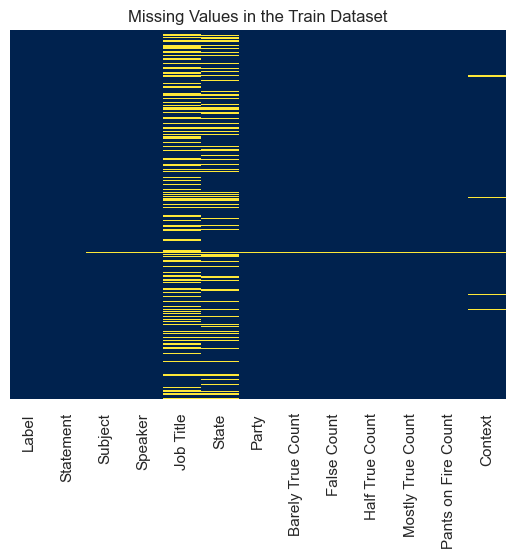

Missing Values Handled and Unnecessary Rows and Column Dropped!


C:\Users\Lena\AppData\Local\Temp\ipykernel_16544\804381262.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


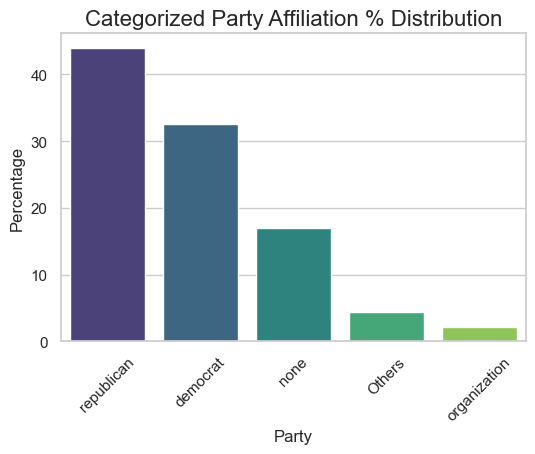

Party Categorization Completed!
Text Cleaning Completed!


C:\Users\Lena\AppData\Local\Temp\ipykernel_16544\804381262.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Adjusted Credit History"] = df.apply(compute_adjusted_credit_history, axis=1)
C:\Users\Lena\AppData\Local\Temp\ipykernel_16544\804381262.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Adjusted Credit History"] = df.apply(compute_adjusted_credit_history, axis=1)
C:\Users\Lena\AppData\Local\Temp\ipykernel_16544\804381262.py:170: SettingWithCopyWarning: 
A value is trying to be set on

Credit history adjustment Completed!
Class Mapping: {np.str_('FALSE'): np.int64(0), np.str_('TRUE'): np.int64(1), np.str_('barely-true'): np.int64(2), np.str_('half-true'): np.int64(3), np.str_('mostly-true'): np.int64(4), np.str_('pants-fire'): np.int64(5)}
Encoding applied to train_df:
         Label  Label_encoded
1        FALSE              0
2    half-true              3
3  mostly-true              4
4        FALSE              0
5    half-true              3
Encoding applied to test_df:
        Label  Label_encoded
1        TRUE              1
2       FALSE              0
3       FALSE              0
4   half-true              3
5  pants-fire              5
Encoding applied to valid_df:
         Label  Label_encoded
1  barely-true              2
2   pants-fire              5
3        FALSE              0
4    half-true              3
5    half-true              3
Labels encoding completed!
train_df False Ratio feature created!
   False Ratio
1     1.000000
2     0.000000
3     0.

c:\Uni\DSLab\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy: 0.3099688473520249
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.52      0.46       263
           1       0.27      0.25      0.26       169
           2       0.25      0.17      0.20       237
           3       0.27      0.35      0.30       248
           4       0.28      0.29      0.29       251
           5       0.41      0.17      0.24       116

    accuracy                           0.31      1284
   macro avg       0.31      0.29      0.29      1284
weighted avg       0.31      0.31      0.30      1284

Test Accuracy: 0.2904498816101026
Test Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.52      0.45       249
           1       0.25      0.21      0.23       208
           2       0.25      0.19      0.22       212
           3       0.27      0.33      0.30       265
           4       0.21      0.23      0.22     

In [355]:
pipeline.run_pipeline()



In [70]:
eda.data_sets_shapes() 

Train Shape: (10270, 14), Test Shape: (1268, 14), Validation Shape: (1285, 14)


In [76]:
# missing values 
eda.missing_values()

Train Missing Values:
ID                        0
Label                     0
Statement                 0
Subject                   6
Speaker                   6
Job Title              2907
State                  2216
Party                     6
Barely True Count         6
False Count               6
Half True Count           6
Mostly True Count         6
Pants on Fire Count       6
Context                 106
dtype: int64
Test Missing Values:
ID                       0
Label                    0
Statement                0
Subject                  0
Speaker                  0
Job Title              325
State                  262
Party                    0
Barely True Count        0
False Count              0
Half True Count          0
Mostly True Count        0
Pants on Fire Count      0
Context                 17
dtype: int64
Validation Missing Values:
ID                       0
Label                    0
Statement                0
Subject                  0
Speaker                  0

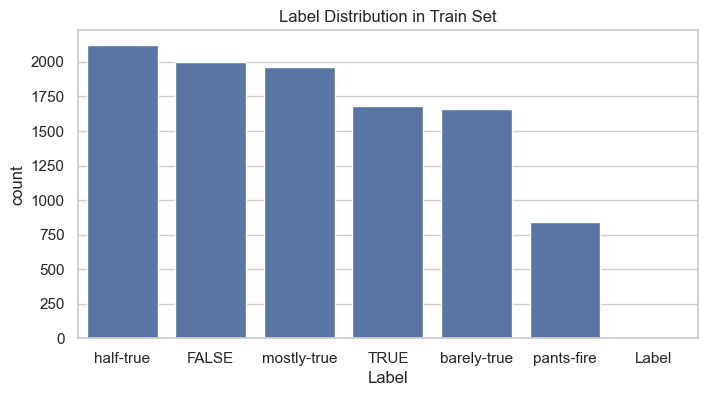

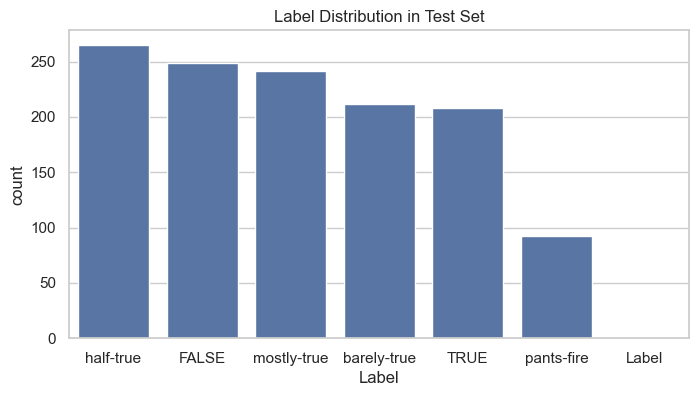

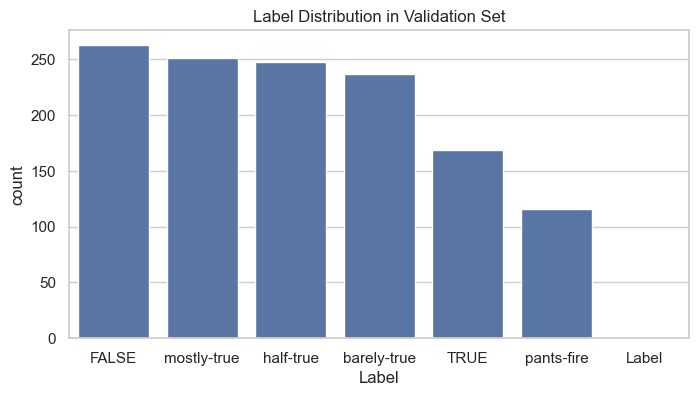

In [77]:
eda.label_distribution()

         Label  proportion
0    half-true   20.671860
1        FALSE   19.454722
2  mostly-true   19.143135
3         TRUE   16.387537
4  barely-true   16.134372
5   pants-fire    8.198637
         Label  Percentage
0    half-true   20.671860
1        FALSE   19.454722
2  mostly-true   19.143135
3         TRUE   16.387537
4  barely-true   16.134372
5   pants-fire    8.198637
Total Percentage for Train Set: 99.99026290165531


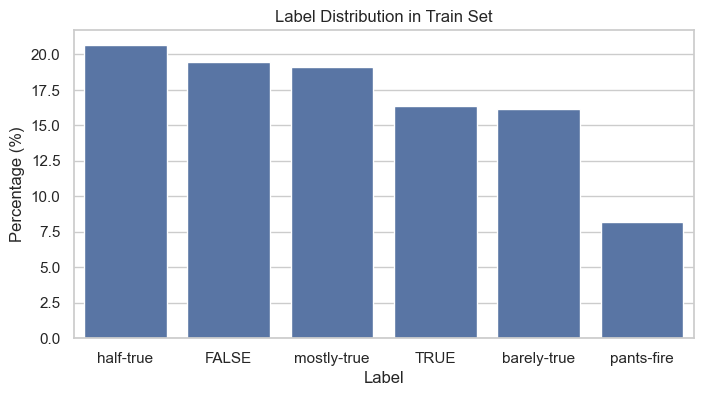

         Label  proportion
0    half-true   20.899054
1        FALSE   19.637224
2  mostly-true   19.006309
3  barely-true   16.719243
4         TRUE   16.403785
5   pants-fire    7.255521
         Label  Percentage
0    half-true   20.899054
1        FALSE   19.637224
2  mostly-true   19.006309
3  barely-true   16.719243
4         TRUE   16.403785
5   pants-fire    7.255521
Total Percentage for Test Set: 99.9211356466877


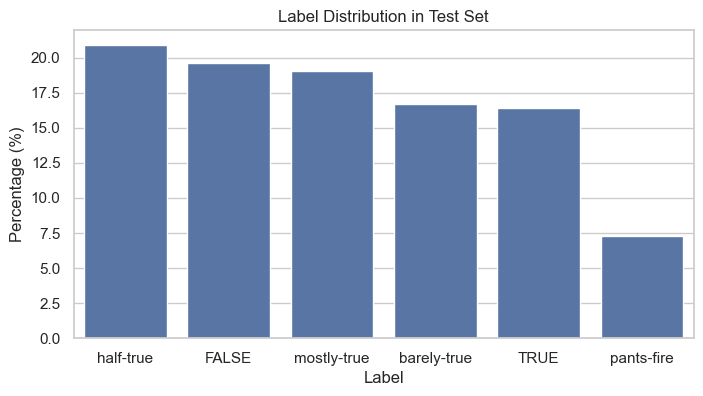

         Label  proportion
0        FALSE   20.466926
1  mostly-true   19.533074
2    half-true   19.299611
3  barely-true   18.443580
4         TRUE   13.151751
5   pants-fire    9.027237
         Label  Percentage
0        FALSE   20.466926
1  mostly-true   19.533074
2    half-true   19.299611
3  barely-true   18.443580
4         TRUE   13.151751
5   pants-fire    9.027237
Total Percentage for Validation Set: 99.92217898832685


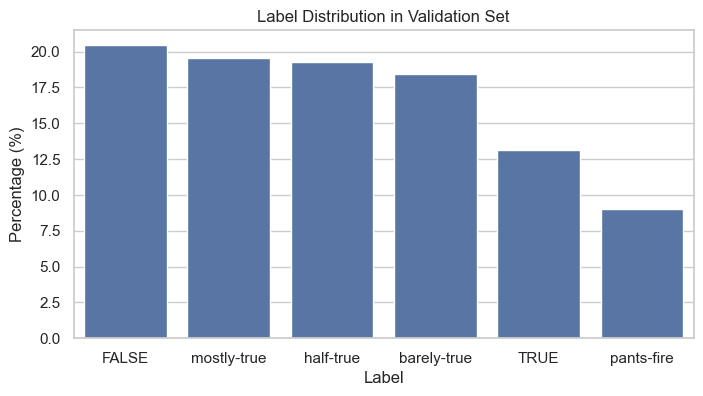

In [78]:
eda.label_distribution_percentage()

In [79]:
eda.word_count()

Train Word Count Summary:
count    10270.000000
mean        17.913729
std          7.767758
min          1.000000
25%         12.000000
50%         17.000000
75%         22.000000
max         66.000000
Name: Word Count, dtype: float64
Test Word Count Summary:
count    1268.000000
mean       18.390379
std        14.894678
min         1.000000
25%        12.000000
50%        16.000000
75%        23.000000
max       431.000000
Name: Word Count, dtype: float64
Validation Word Count Summary:
count    1285.000000
mean       17.912062
std         7.712971
min         1.000000
25%        12.000000
50%        17.000000
75%        22.000000
max        57.000000
Name: Word Count, dtype: float64


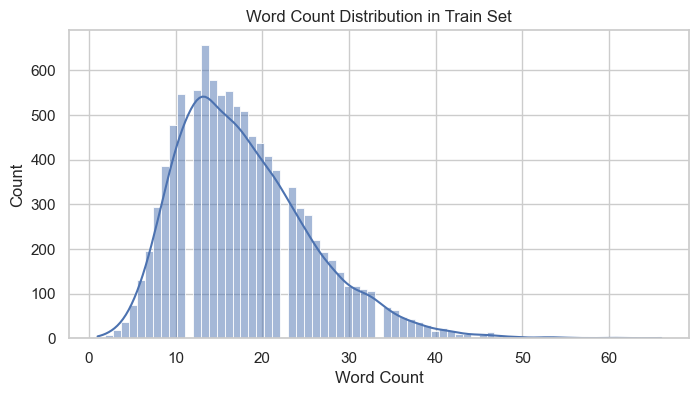

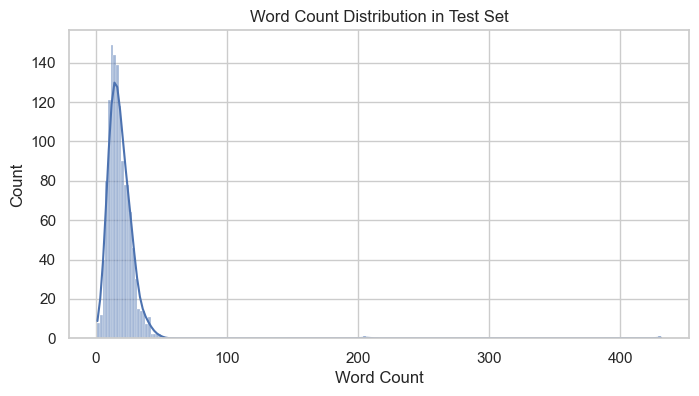

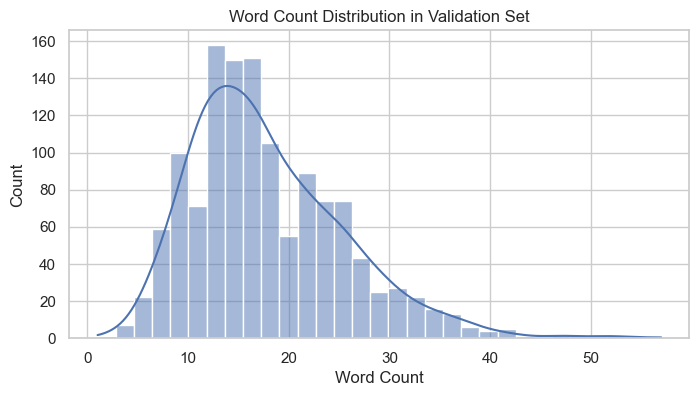

In [80]:
eda.word_count_distr()


Train Set data:

                  mean    sum  count
Label                               
FALSE        16.819820  33606   1998
TRUE         17.903743  30132   1683
barely-true  18.154496  30082   1657
half-true    18.783325  39877   2123
mostly-true  18.234486  35849   1966
pants-fire   17.134204  14427    842


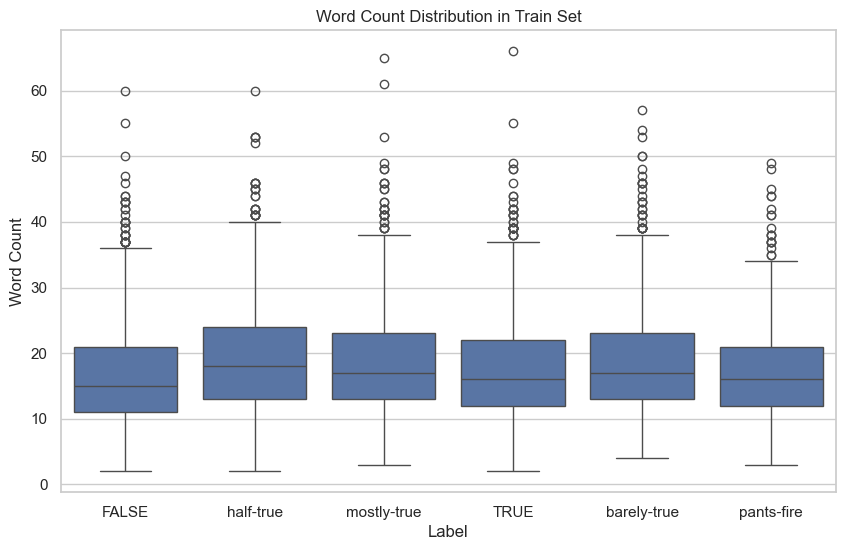

Test Set data:

                  mean   sum  count
Label                              
FALSE        16.433735  4092    249
TRUE         18.653846  3880    208
barely-true  18.061321  3829    212
half-true    19.803774  5248    265
mostly-true  18.979253  4574    241
pants-fire   18.423913  1695     92


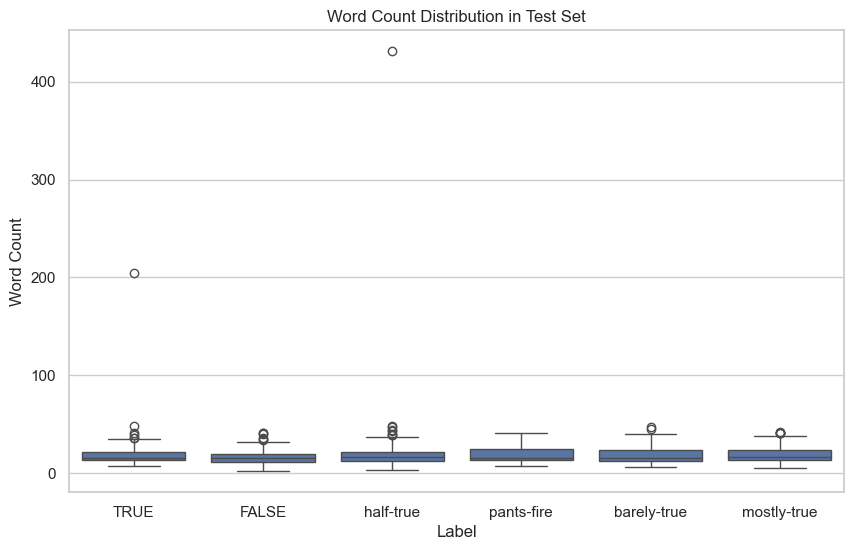

Validation Set data:

                  mean   sum  count
Label                              
FALSE        16.433460  4322    263
TRUE         17.420118  2944    169
barely-true  18.181435  4309    237
half-true    19.451613  4824    248
mostly-true  18.454183  4632    251
pants-fire   17.112069  1985    116


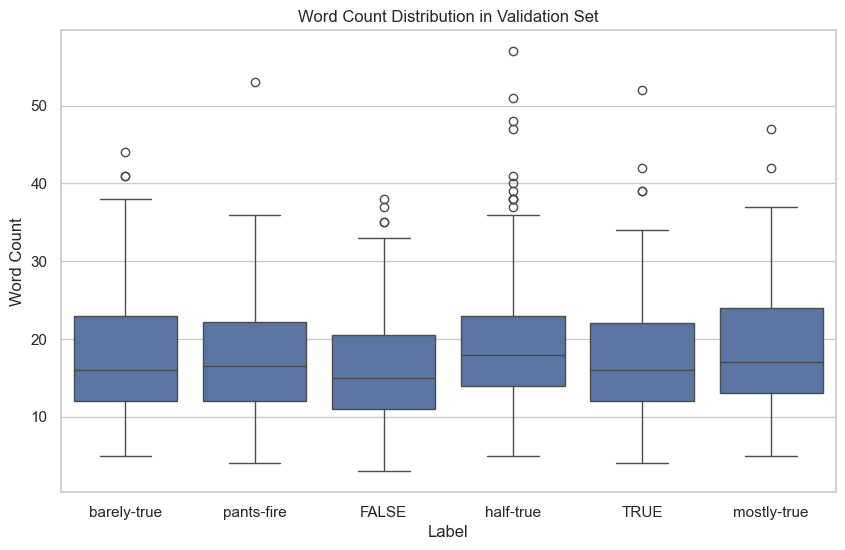

In [81]:
eda.word_count_by_labels()

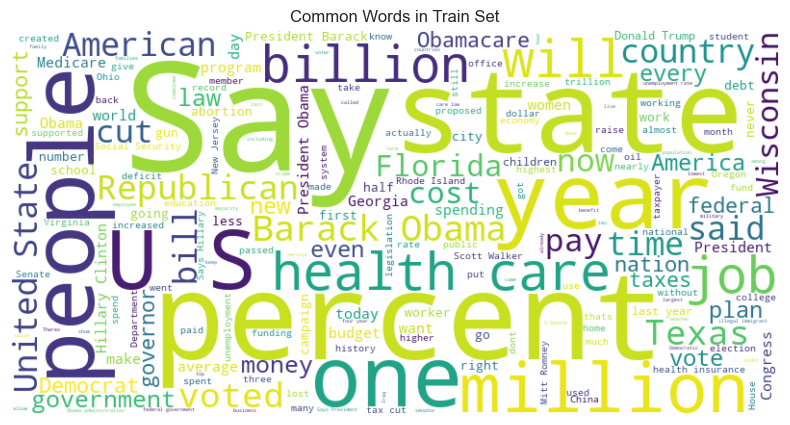

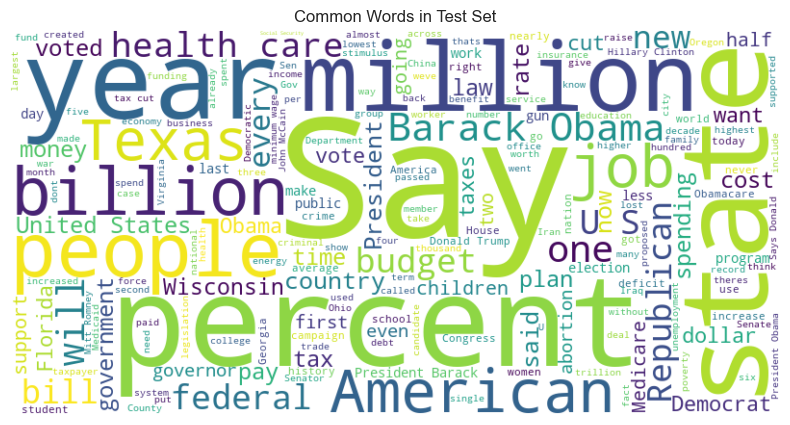

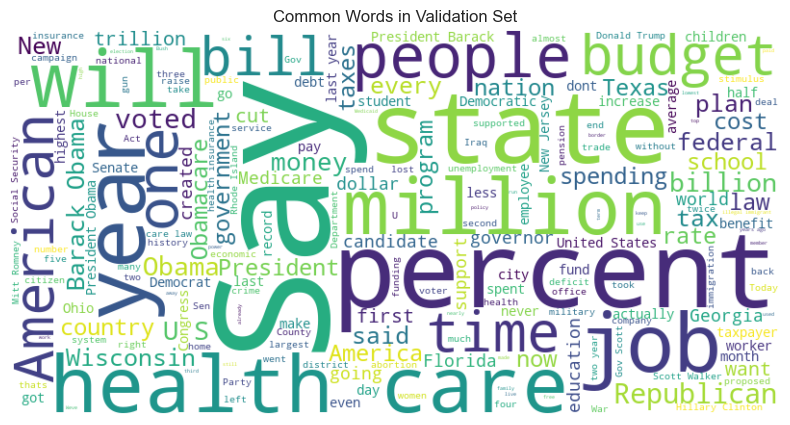

In [82]:
eda.word_cloud()

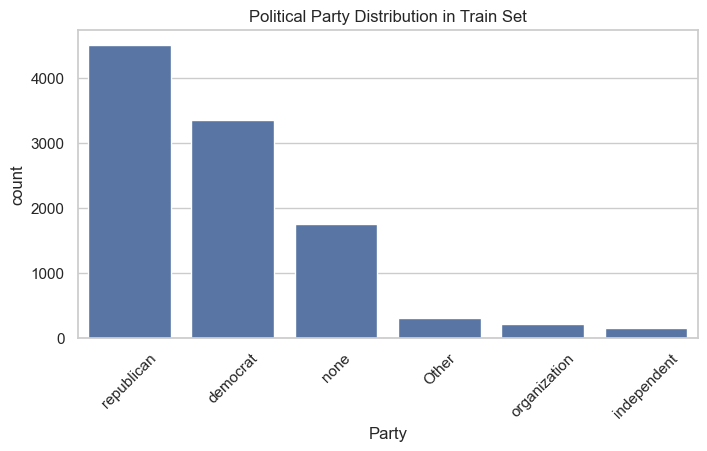

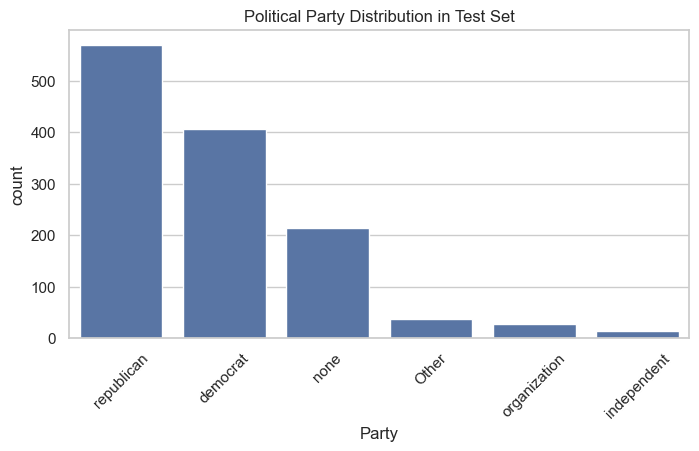

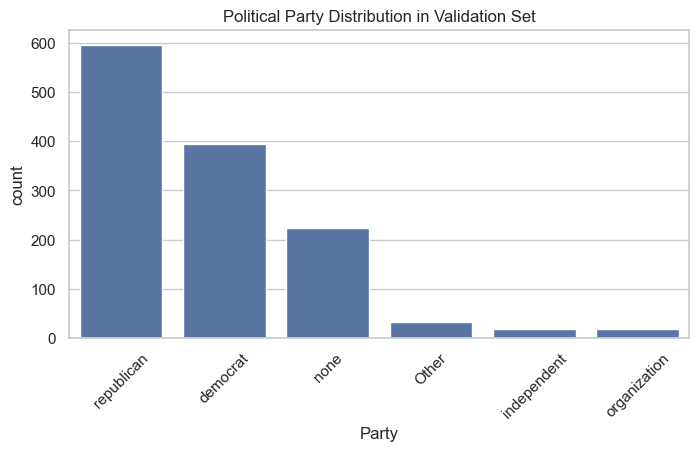

In [83]:
eda.polical_party_distr()

In [84]:
eda.speaker_frequency()


Top 10 Speakers in Train Set:
Speaker
barack-obama       491
donald-trump       274
hillary-clinton    239
mitt-romney        179
scott-walker       150
john-mccain        148
rick-perry         142
chain-email        142
marco-rubio        117
rick-scott         115
Name: count, dtype: int64
Top 10 Speakers in Test Set:
Speaker
barack-obama       62
donald-trump       33
hillary-clinton    31
rick-scott         21
john-mccain        21
scott-walker       17
mitt-romney        17
rick-perry         17
marco-rubio        14
chris-christie     13
Name: count, dtype: int64
Top 10 Speakers in Validation Set:
Speaker
barack-obama       61
donald-trump       37
hillary-clinton    27
chain-email        23
marco-rubio        22
john-mccain        20
mitt-romney        19
scott-walker       17
ted-cruz           14
rick-scott         14
Name: count, dtype: int64


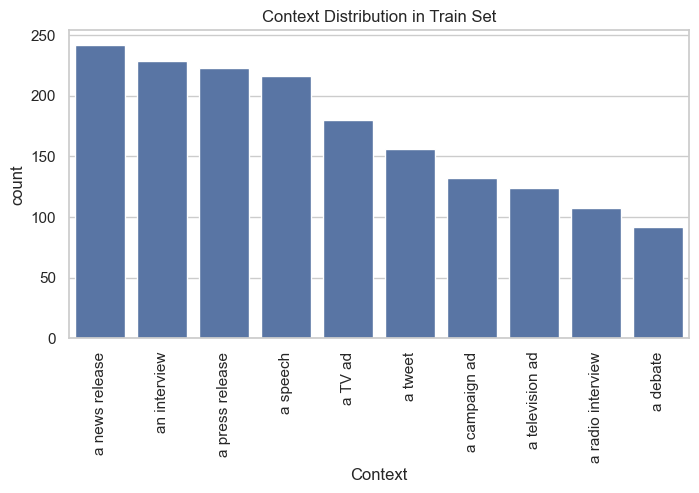

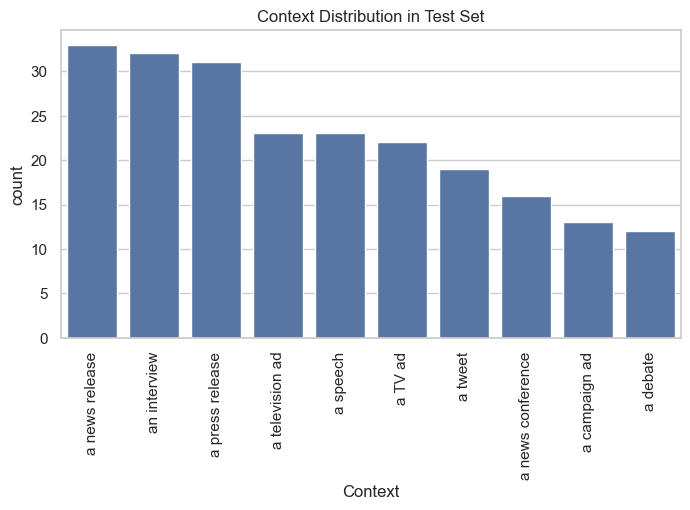

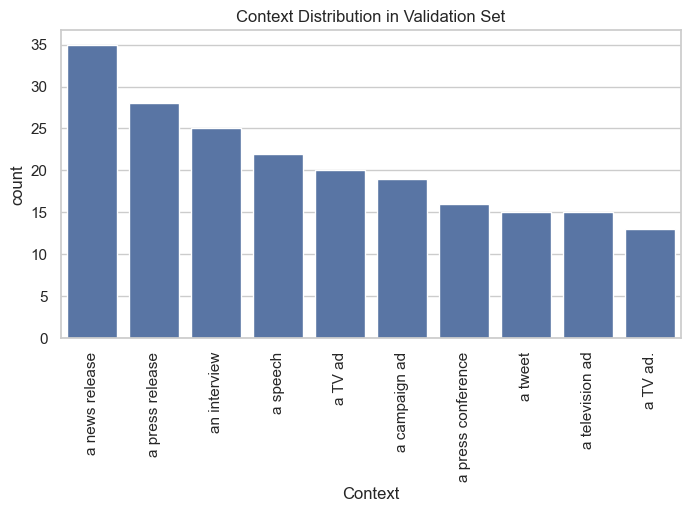

In [85]:
eda.context_analysis()


C:\Users\Lena\AppData\Local\Temp\ipykernel_16544\1463770371.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['Party'] = df_c['Party'].apply(lambda x: x if x in top_parties else 'Other')


Train data set
\begin{table}
\caption{Number of Statements in Each Category by Party Affiliation}
\label{tab:statements_by_party}
\begin{tabular}{lrrrrrr}
\toprule
Label & FALSE & TRUE & barely-true & half-true & mostly-true & pants-fire \\
Party &  &  &  &  &  &  \\
\midrule
\textbf{Other} & 457 & 361 & 360 & 477 & 456 & 308 \\
\textbf{democrat} & 512 & 660 & 463 & 752 & 801 & 154 \\
\textbf{republican} & 1029 & 662 & 834 & 894 & 709 & 380 \\
\bottomrule
\end{tabular}
\end{table}



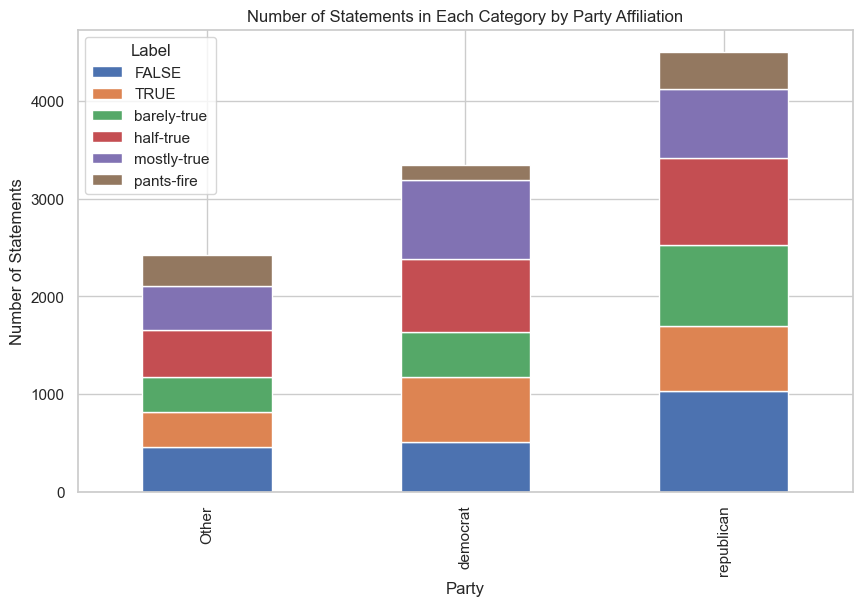

C:\Users\Lena\AppData\Local\Temp\ipykernel_16544\1463770371.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['Party'] = df_c['Party'].apply(lambda x: x if x in top_parties else 'Other')


Test data set
\begin{table}
\caption{Number of Statements in Each Category by Party Affiliation}
\label{tab:statements_by_party}
\begin{tabular}{lrrrrrr}
\toprule
Label & FALSE & TRUE & barely-true & half-true & mostly-true & pants-fire \\
Party &  &  &  &  &  &  \\
\midrule
\textbf{Other} & 61 & 43 & 48 & 45 & 47 & 46 \\
\textbf{democrat} & 57 & 90 & 64 & 87 & 95 & 13 \\
\textbf{republican} & 131 & 75 & 100 & 133 & 99 & 33 \\
\bottomrule
\end{tabular}
\end{table}



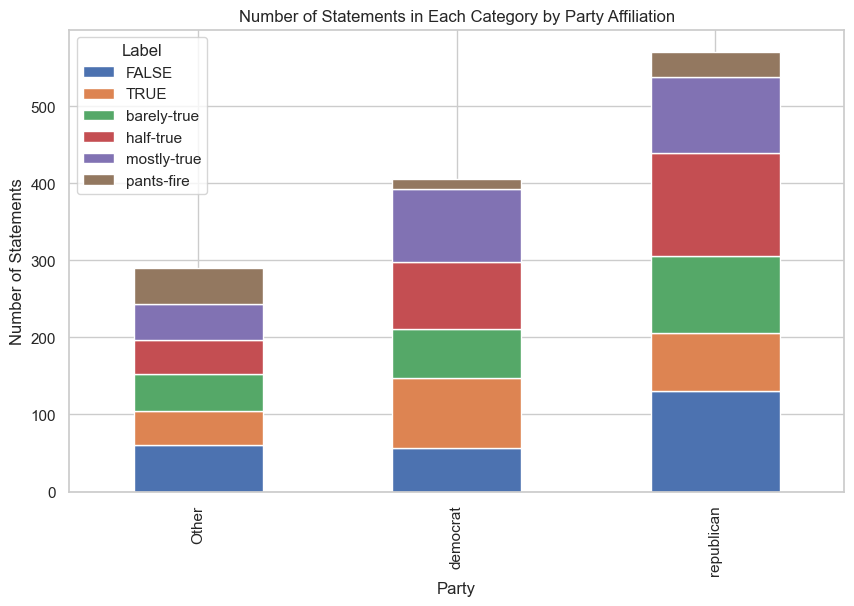

C:\Users\Lena\AppData\Local\Temp\ipykernel_16544\1463770371.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['Party'] = df_c['Party'].apply(lambda x: x if x in top_parties else 'Other')


Validation data set
\begin{table}
\caption{Number of Statements in Each Category by Party Affiliation}
\label{tab:statements_by_party}
\begin{tabular}{lrrrrrr}
\toprule
Label & FALSE & TRUE & barely-true & half-true & mostly-true & pants-fire \\
Party &  &  &  &  &  &  \\
\midrule
\textbf{Other} & 58 & 37 & 49 & 44 & 55 & 49 \\
\textbf{democrat} & 65 & 59 & 59 & 94 & 99 & 19 \\
\textbf{republican} & 140 & 73 & 129 & 110 & 97 & 48 \\
\bottomrule
\end{tabular}
\end{table}



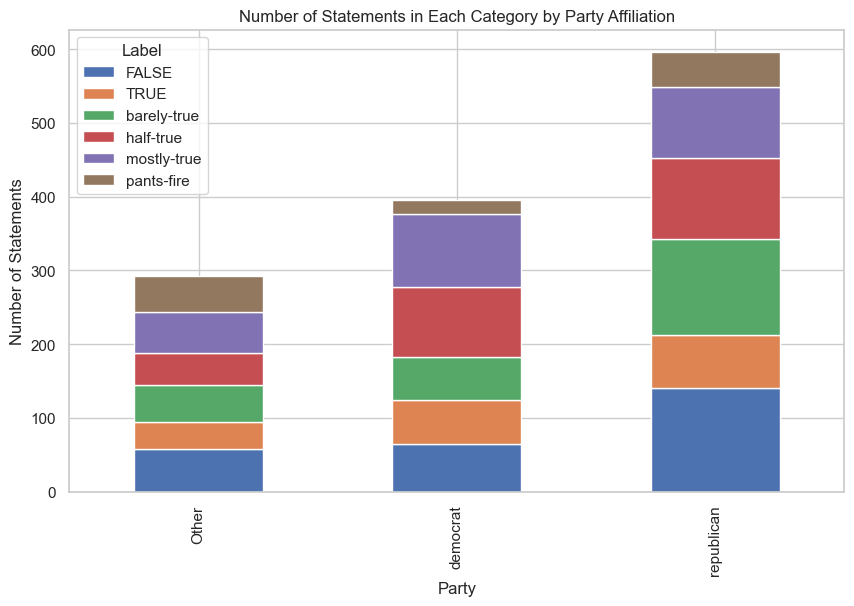

In [86]:
eda.truthfullness_by_party()

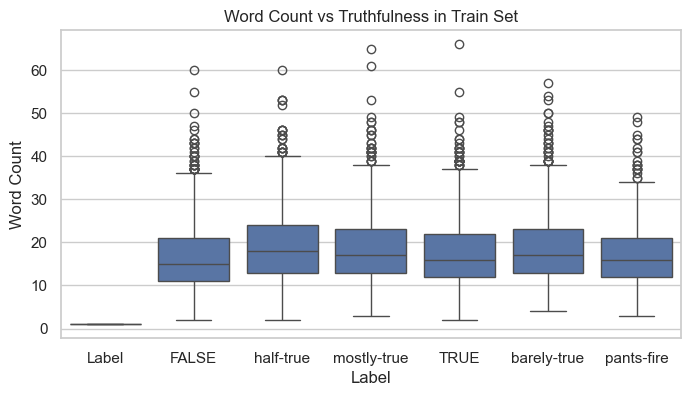

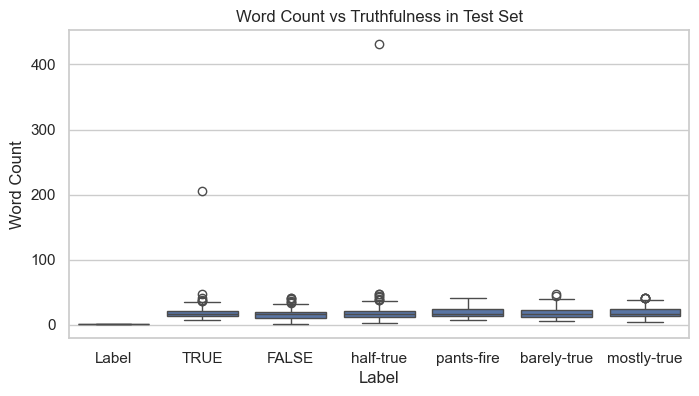

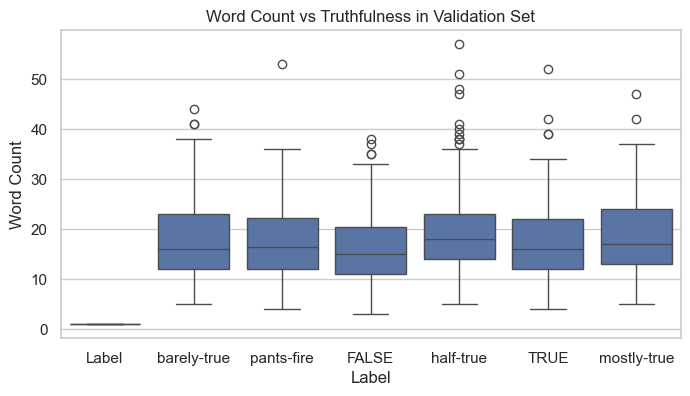

In [87]:
eda.word_count_vs_thuthfullness()

C:\Users\Lena\AppData\Local\Temp\ipykernel_16544\1463770371.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['Party'] = df_c['Party'].apply(lambda x: x if x in top_parties else 'Other')


Train data set
Label       FALSE  TRUE  barely-true  half-true  mostly-true  pants-fire
Party                                                                   
Other        18.9  14.9         14.9       19.7         18.9        12.7
democrat     15.3  19.7         13.9       22.5         24.0         4.6
republican   22.8  14.7         18.5       19.8         15.7         8.4
Train data set
\begin{table}
\caption{Percent of Statements in Each Category by Party Affiliation. Train set}
\label{tab:statements_by_party}
\begin{tabular}{lrrrrrr}
\toprule
Label & FALSE & TRUE & barely-true & half-true & mostly-true & pants-fire \\
Party &  &  &  &  &  &  \\
\midrule
\textbf{Other} & 18.9 & 14.9 & 14.9 & 19.7 & 18.9 & 12.7 \\
\textbf{democrat} & 15.3 & 19.7 & 13.9 & 22.5 & 24.0 & 4.6 \\
\textbf{republican} & 22.8 & 14.7 & 18.5 & 19.8 & 15.7 & 8.4 \\
\bottomrule
\end{tabular}
\end{table}



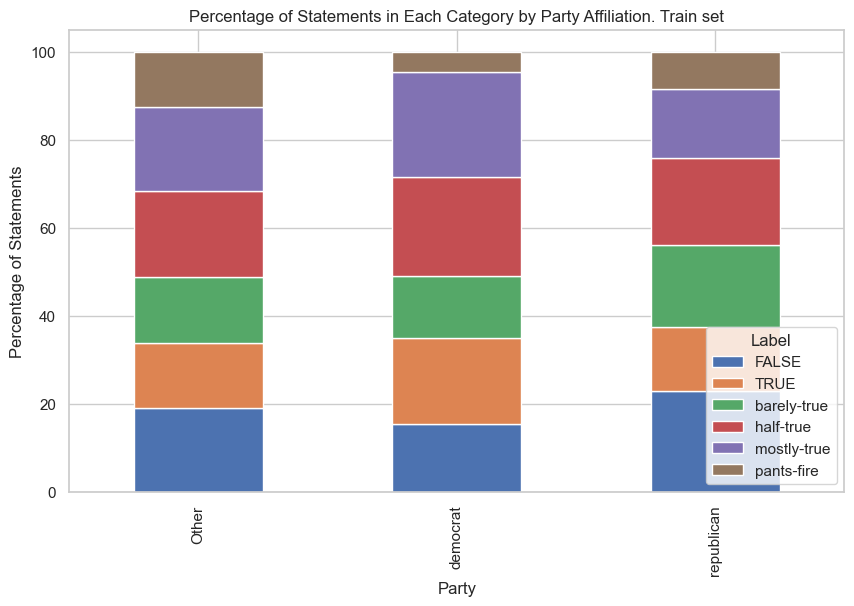

C:\Users\Lena\AppData\Local\Temp\ipykernel_16544\1463770371.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['Party'] = df_c['Party'].apply(lambda x: x if x in top_parties else 'Other')


Test data set
Label       FALSE  TRUE  barely-true  half-true  mostly-true  pants-fire
Party                                                                   
Other        21.0  14.8         16.6       15.5         16.2        15.9
democrat     14.0  22.2         15.8       21.4         23.4         3.2
republican   22.9  13.1         17.5       23.3         17.3         5.8
Test data set
\begin{table}
\caption{Percent of Statements in Each Category by Party Affiliation. Test set}
\label{tab:statements_by_party}
\begin{tabular}{lrrrrrr}
\toprule
Label & FALSE & TRUE & barely-true & half-true & mostly-true & pants-fire \\
Party &  &  &  &  &  &  \\
\midrule
\textbf{Other} & 21.0 & 14.8 & 16.6 & 15.5 & 16.2 & 15.9 \\
\textbf{democrat} & 14.0 & 22.2 & 15.8 & 21.4 & 23.4 & 3.2 \\
\textbf{republican} & 22.9 & 13.1 & 17.5 & 23.3 & 17.3 & 5.8 \\
\bottomrule
\end{tabular}
\end{table}



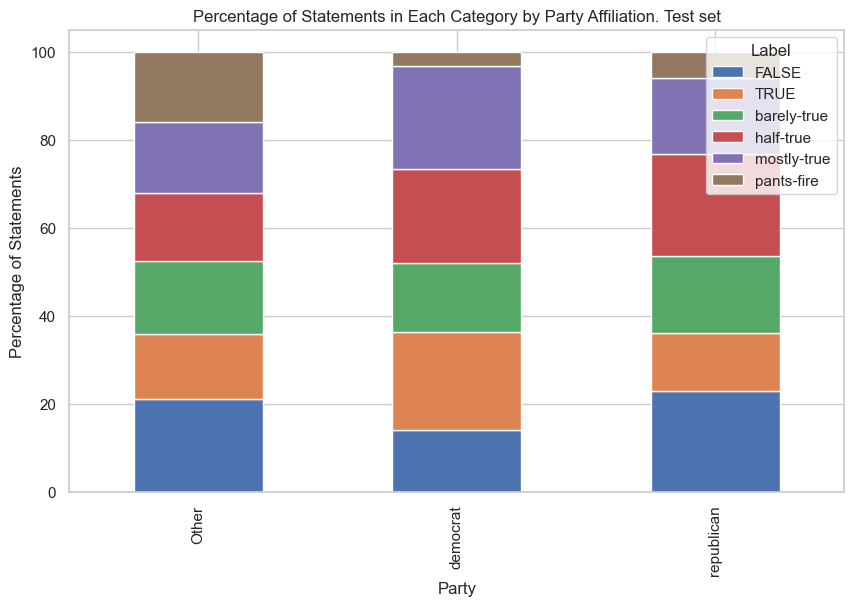

C:\Users\Lena\AppData\Local\Temp\ipykernel_16544\1463770371.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['Party'] = df_c['Party'].apply(lambda x: x if x in top_parties else 'Other')


Validation data set
Label       FALSE  TRUE  barely-true  half-true  mostly-true  pants-fire
Party                                                                   
Other        19.9  12.7         16.8       15.1         18.8        16.8
democrat     16.5  14.9         14.9       23.8         25.1         4.8
republican   23.5  12.2         21.6       18.4         16.2         8.0
Validation data set
\begin{table}
\caption{Percent of Statements in Each Category by Party Affiliation. Validation set}
\label{tab:statements_by_party}
\begin{tabular}{lrrrrrr}
\toprule
Label & FALSE & TRUE & barely-true & half-true & mostly-true & pants-fire \\
Party &  &  &  &  &  &  \\
\midrule
\textbf{Other} & 19.9 & 12.7 & 16.8 & 15.1 & 18.8 & 16.8 \\
\textbf{democrat} & 16.5 & 14.9 & 14.9 & 23.8 & 25.1 & 4.8 \\
\textbf{republican} & 23.5 & 12.2 & 21.6 & 18.4 & 16.2 & 8.0 \\
\bottomrule
\end{tabular}
\end{table}



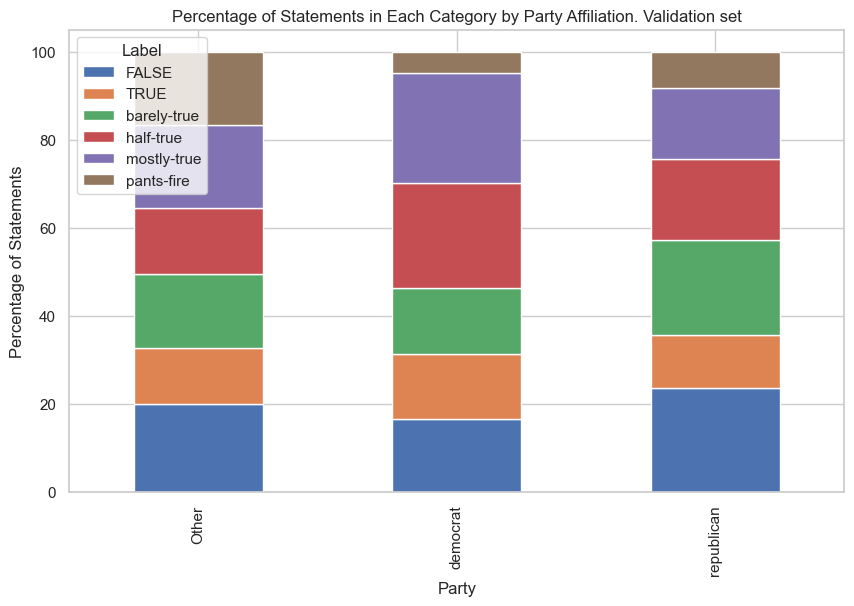

In [88]:
eda.truthfullness_by_party_percents()

C:\Users\Lena\AppData\Local\Temp\ipykernel_16544\1463770371.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['Context'] = df_c['Context'].apply(lambda x: x if x in top_parties else 'Other')


Train data set
Label            FALSE  TRUE  barely-true  half-true  mostly-true  pants-fire
Context                                                                      
Other             19.5  16.3         16.2       20.5         19.0         8.4
a TV ad           15.0  10.6         21.7       25.6         20.0         7.2
a news release    18.2  18.2         18.6       19.0         16.9         9.1
a press release   18.4  19.7         15.2       20.6         20.2         5.8
a speech          15.7  20.4         11.6       25.5         23.1         3.7
an interview      25.3  14.8         13.1       20.5         20.5         5.7
Train data set
\begin{table}
\caption{Percent of Statements in Each Category by Party Affiliation. Train set}
\label{tab:statements_by_party}
\begin{tabular}{lrrrrrr}
\toprule
Label & FALSE & TRUE & barely-true & half-true & mostly-true & pants-fire \\
Context &  &  &  &  &  &  \\
\midrule
\textbf{Other} & 19.5 & 16.3 & 16.2 & 20.5 & 19.0 & 8.4 \\
\textbf{a T

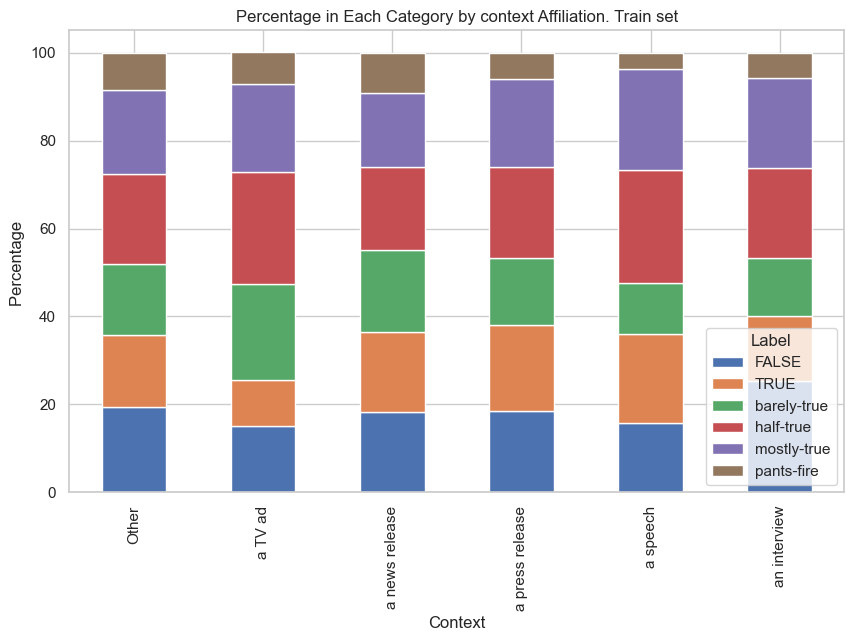

C:\Users\Lena\AppData\Local\Temp\ipykernel_16544\1463770371.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['Context'] = df_c['Context'].apply(lambda x: x if x in top_parties else 'Other')


Test data set
Label            FALSE  TRUE  barely-true  half-true  mostly-true  pants-fire
Context                                                                      
Other             19.6  16.1         16.4       21.2         19.2         7.4
a news release    27.3   6.1         27.3       18.2          6.1        15.2
a press release   12.9  25.8         16.1       22.6         22.6         0.0
a speech          21.7  47.8          4.3        4.3         21.7         0.0
a television ad   17.4   4.3         21.7       26.1         13.0        17.4
an interview      18.8  15.6         21.9       18.8         25.0         0.0
Test data set
\begin{table}
\caption{Percent of Statements in Each Category by Party Affiliation. Test set}
\label{tab:statements_by_party}
\begin{tabular}{lrrrrrr}
\toprule
Label & FALSE & TRUE & barely-true & half-true & mostly-true & pants-fire \\
Context &  &  &  &  &  &  \\
\midrule
\textbf{Other} & 19.6 & 16.1 & 16.4 & 21.2 & 19.2 & 7.4 \\
\textbf{a news

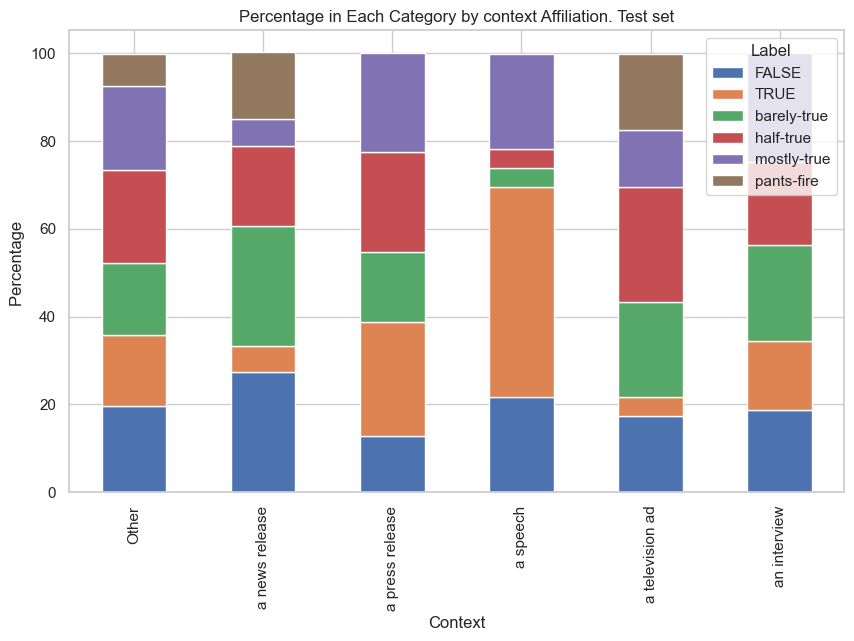

C:\Users\Lena\AppData\Local\Temp\ipykernel_16544\1463770371.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['Context'] = df_c['Context'].apply(lambda x: x if x in top_parties else 'Other')


Validation data set
Label            FALSE  TRUE  barely-true  half-true  mostly-true  pants-fire
Context                                                                      
Other             20.7  13.3         18.3       18.8         19.0         9.9
a TV ad           40.0  15.0         10.0       15.0         15.0         5.0
a news release    17.1  17.1         22.9       22.9         20.0         0.0
a press release   10.7  10.7         28.6       21.4         28.6         0.0
a speech          13.6  13.6         13.6       36.4         22.7         0.0
an interview      16.0   0.0         20.0       24.0         36.0         4.0
Validation data set
\begin{table}
\caption{Percent of Statements in Each Category by Party Affiliation. Validation set}
\label{tab:statements_by_party}
\begin{tabular}{lrrrrrr}
\toprule
Label & FALSE & TRUE & barely-true & half-true & mostly-true & pants-fire \\
Context &  &  &  &  &  &  \\
\midrule
\textbf{Other} & 20.7 & 13.3 & 18.3 & 18.8 & 19.0 & 9.9

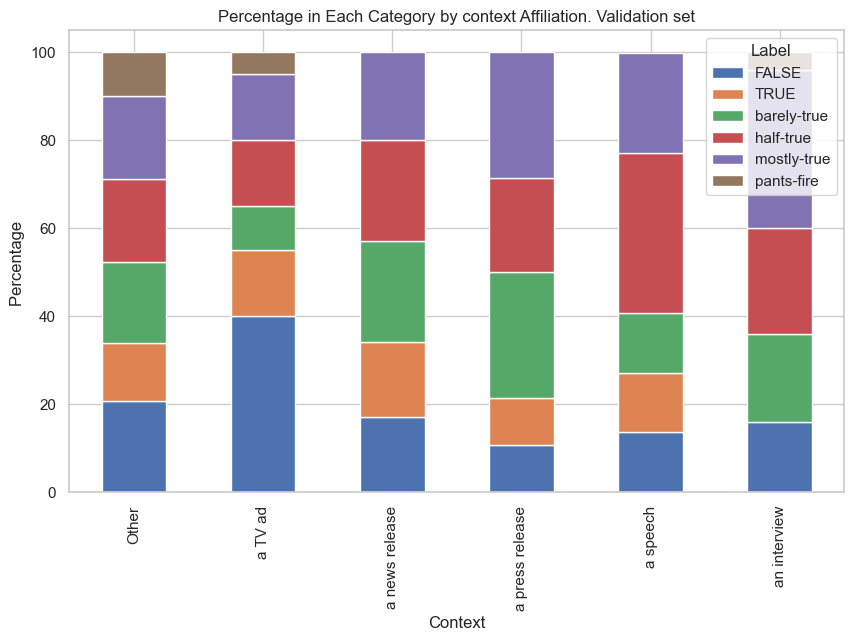

In [89]:
eda.truthfullness_by_context_percents()

C:\Users\Lena\AppData\Local\Temp\ipykernel_16544\2454151424.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['Speaker'] = df_c['Speaker'].apply(lambda x: x if x in top_parties else 'Other')


Train data set
Label            FALSE  TRUE  barely-true  half-true  mostly-true  pants-fire
Speaker                                                                      
Other             19.4  16.3         16.5       20.5         18.8         8.4
barack-obama      13.8  21.4         11.4       25.3         26.5         1.6
donald-trump      37.2   2.2         17.5       14.2          9.9        19.0
hillary-clinton   11.3  25.1         12.6       21.3         27.2         2.5
mitt-romney       15.6  16.8         15.1       27.4         15.6         9.5
scott-walker      23.3  14.0         15.3       19.3         22.7         5.3
Train data set
\begin{table}
\caption{Percent of Statements in Each Category by Speaker. Train set}
\label{tab:statement_by_speaker}
\begin{tabular}{lrrrrrr}
\toprule
Label & FALSE & TRUE & barely-true & half-true & mostly-true & pants-fire \\
Speaker &  &  &  &  &  &  \\
\midrule
\textbf{Other} & 19.4 & 16.3 & 16.5 & 20.5 & 18.8 & 8.4 \\
\textbf{barack-obama

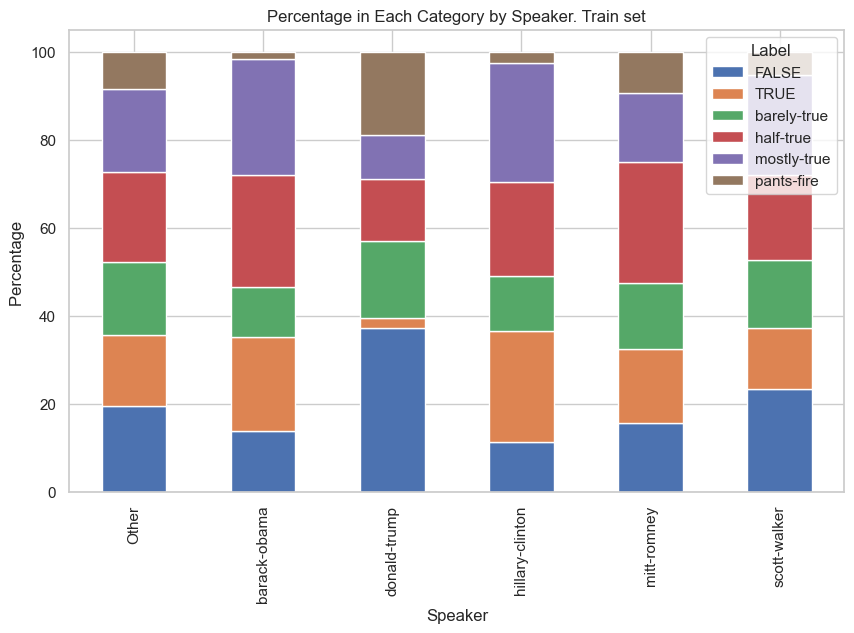

C:\Users\Lena\AppData\Local\Temp\ipykernel_16544\2454151424.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['Speaker'] = df_c['Speaker'].apply(lambda x: x if x in top_parties else 'Other')


Test data set
Label            FALSE  TRUE  barely-true  half-true  mostly-true  pants-fire
Speaker                                                                      
Other             20.7  16.0         16.5       20.1         18.7         8.1
barack-obama      12.9  19.4          8.1       29.0         30.6         0.0
donald-trump      18.2  12.1         27.3       21.2         12.1         9.1
hillary-clinton    6.5  29.0         22.6       29.0         12.9         0.0
john-mccain        9.5  33.3         14.3       19.0         23.8         0.0
rick-scott        19.0   0.0         33.3       28.6         19.0         0.0
Test data set
\begin{table}
\caption{Percent of Statements in Each Category by Speaker. Test set}
\label{tab:statement_by_speaker}
\begin{tabular}{lrrrrrr}
\toprule
Label & FALSE & TRUE & barely-true & half-true & mostly-true & pants-fire \\
Speaker &  &  &  &  &  &  \\
\midrule
\textbf{Other} & 20.7 & 16.0 & 16.5 & 20.1 & 18.7 & 8.1 \\
\textbf{barack-obama} &

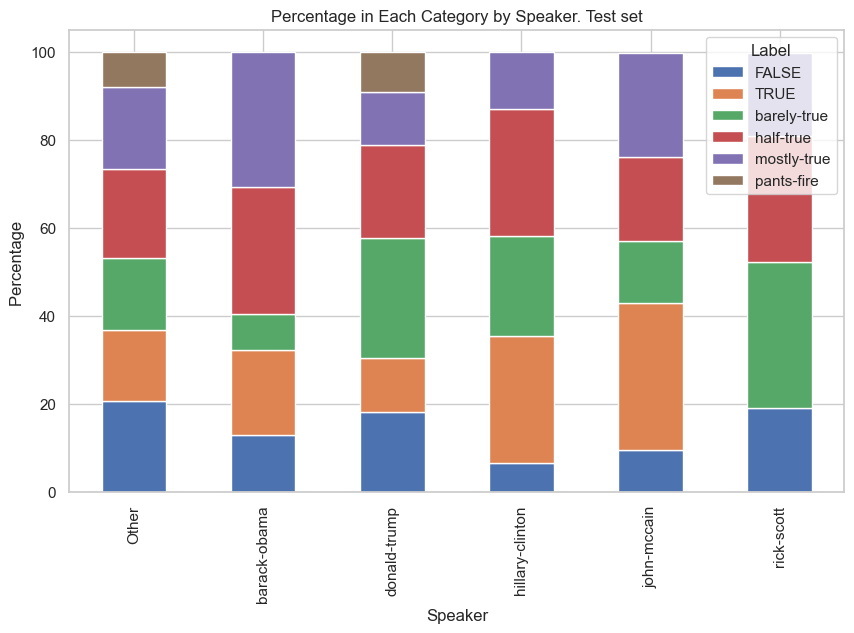

C:\Users\Lena\AppData\Local\Temp\ipykernel_16544\2454151424.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['Speaker'] = df_c['Speaker'].apply(lambda x: x if x in top_parties else 'Other')


Validation data set
Label            FALSE  TRUE  barely-true  half-true  mostly-true  pants-fire
Speaker                                                                      
Other             21.1  13.6         19.1       18.8         19.6         7.9
barack-obama       9.8  13.1         14.8       37.7         23.0         1.6
chain-email       21.7   0.0          4.3        0.0          0.0        73.9
donald-trump      27.0  10.8         16.2       13.5         16.2        16.2
hillary-clinton   11.1  14.8         11.1       33.3         25.9         3.7
marco-rubio       18.2   9.1         22.7        9.1         27.3        13.6
Validation data set
\begin{table}
\caption{Percent of Statements in Each Category by Speaker. Validation set}
\label{tab:statement_by_speaker}
\begin{tabular}{lrrrrrr}
\toprule
Label & FALSE & TRUE & barely-true & half-true & mostly-true & pants-fire \\
Speaker &  &  &  &  &  &  \\
\midrule
\textbf{Other} & 21.1 & 13.6 & 19.1 & 18.8 & 19.6 & 7.9 \\
\text

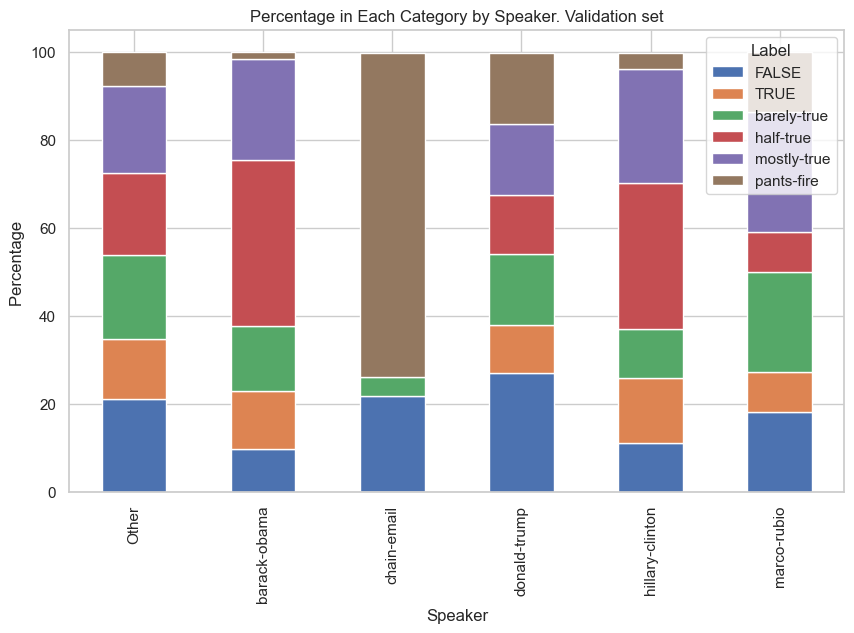

In [93]:
eda.truthfulness_by_speaker_percents()